# SQL analysis with differential privacy guarantees 

The purpose of this notebook is to illustrate the process of **transforming a standard SQL query into a differentially private SQL** query, meaning that its results are designed to satisfy differential privacy principles. 
Our goal here is to demonstrate how this complex transformation of an SQL query into a differentially private version can be achieved with ease using Qrlew.

The main idea of Qrlew is to parse and compile SQL queries into an [Intermediate Representation](https://en.wikipedia.org/wiki/Intermediate_representation) (IR) that is well-suited for various rewriting tasks.

Qrlew **transforms a SQL query into a combination of simple operations** such as `Map`, `Reduce` and `Join` that are applied to `Table`. This representation simplifies the process of rewriting queries and reduces dependencies on the diverse range of syntactic constructs present in SQL.

## Install the database and packages


In [1]:
%%shell
# Load the database
# Inspred by https://colab.research.google.com/github/tensorflow/io/blob/master/docs/tutorials/postgresql.ipynb#scrollTo=YUj0878jPyz7
sudo apt-get -y -qq update
sudo apt-get -y -qq install postgresql-14
# Start postgresql server
sudo sed -i "s/port = 5432/port = 5433/g" /etc/postgresql/14/main/postgresql.conf
sudo service postgresql start
# Set password
sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'pyqrlew-db'"
pip install -U pyqrlew graphviz

UsageError: Cell magic `%%shell` not found.


For our analysis, we will use the Qrlew built-in sample datasets `retail` and an Postgres connection. 

Note that you can also load one or several csv files or use another SQL engine.

In [2]:
from pyqrlew.io import PostgreSQL
# Read data
database = PostgreSQL()
dataset = database.retail()

Error response from daemon: network with name qrlew-net already exists
Error response from daemon: No such container: pyqrlew-db
Error: failed to start containers: pyqrlew-db


9f2cae65eaab3d95c93307e0210725ccc6687f113f5b1c3c6dde4f997e6565d3
/var/run/postgresql:5432 - no response
Waiting postgresql to be ready...
/var/run/postgresql:5432 - accepting connections
SET
SET
SET
SET
SET
 set_config 
------------
 
(1 row)

SET
SET
SET
SET
CREATE SCHEMA
ALTER SCHEMA
SET
SET
CREATE TABLE
ALTER TABLE
CREATE TABLE
ALTER TABLE
CREATE TABLE
ALTER TABLE
COPY 910
COPY 715
COPY 5
ALTER TABLE
ALTER TABLE
ALTER TABLE
ALTER TABLE
ALTER TABLE


## The `Relation`: an intermediate represention for SQL rewritting

The `retail` dataset contains 3 tables, each can be converted into a `Relation::Table`: 

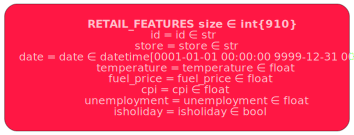

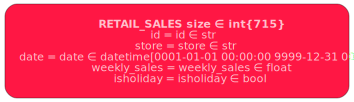

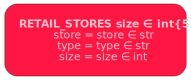

In [3]:
import graphviz
display(graphviz.Source(dataset.relations()[0][1].dot()))
display(graphviz.Source(dataset.relations()[1][1].dot()))
display(graphviz.Source(dataset.relations()[2][1].dot()))

Each `Relation::Table` contains the size of the table (which can be approximate with DP) and the columns in the tables with their name and type.

Before using any differential privacy mechanism, it is essential to determine:
- the *protected entity*, i.e. the *user* identifier, 
- the *sensitivity of the aggregation functions*, i.e. the maximal contribution a user may have on the result,
- the values of the `GROUP BY` columns that can be safely released

## The protected entity

In this example, let's consider that we want to protect the `id` column of the tables `features` and `sales`.

The tables `store` is linked to `features` via foreign keys. 

Then each table have a protected entity (even if it is not directly in the table): 
- `features`: `id`
- `stores`: `store` --> `features`: `store` --> `features`: `id`
- `sales`: `id`

In our formalism, we rewrite this protected entity as: 

In [4]:
protected_entity = [

    ("features", [], "id"),
    ("stores", [("store", "features", "store")], "id"),
    ("sales", [], "id")
]

The `Relation` method `protect` allows to propagate the **protected entity** through all the relations: 

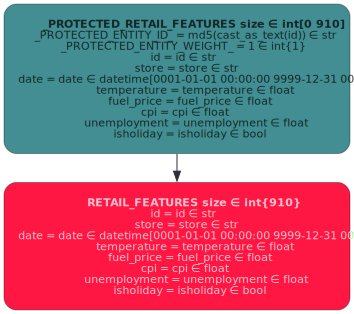

In [5]:
pep_features = dataset.relations()[0][1].protect(dataset, protected_entity)
display(graphviz.Source(pep_features.dot()))

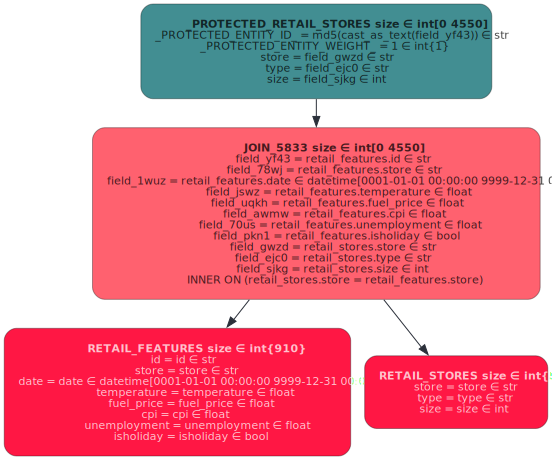

In [6]:
pep_stores = dataset.relations()[2][1].protect(dataset, protected_entity)
display(graphviz.Source(pep_stores.dot()))

We notice that to protect the `features` table we just have to hash the values of the `id` column and store them into the `_PROTECTED_ENTITY_ID_` while to protect the `store` table we had to make a join before. 

The protection can also be extended to an SQL query, ensuring that the resulting dataset does not mix rows belonging to different users. 
This output `Relation` is called **Protected Entity Preserving** (PEP).

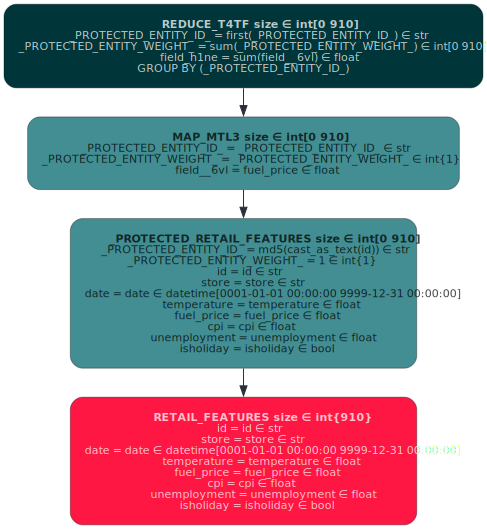

In [7]:
relation = dataset.sql('SELECT SUM(fuel_price) FROM retail.features')
pep_relation = relation.protect(dataset, protected_entity)
display(graphviz.Source(pep_relation.dot()))

## The sensitivity

In the case we want to relase the result of query : `SELECT SUM(3 * fuel_price + temperature / 10) FROM retail.features`, we have to compute the sensitivity of the `SUM(3 * fuel_price + temperature / 10)` aggregation. 

The user provides the ranges of the inputs column in the `WHERE` clause of the query, then these values are propagated through all the relations. 

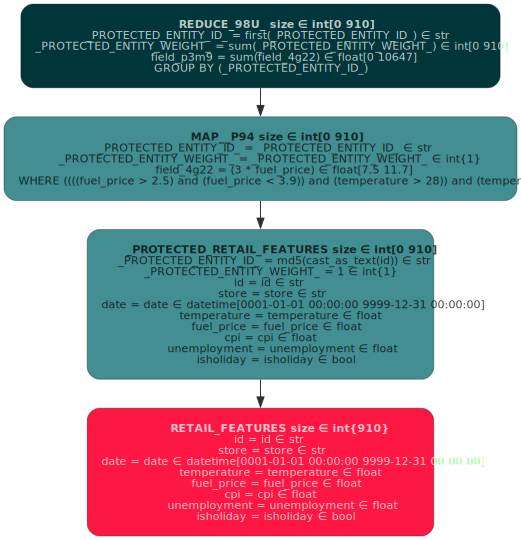

In [8]:
relation = dataset.sql('SELECT SUM(3 * fuel_price) FROM retail.features WHERE fuel_price > 2.5 AND fuel_price < 3.9 AND temperature > 28 AND temperature < 93')
pep_relation = relation.protect(dataset, protected_entity)
display(graphviz.Source(pep_relation.dot()))

More information about the ranges propagation can be found [here](https://github.com/Qrlew/pyqrlew/blob/main/examples/range_propagation.ipynb). 

## The protection of the GROUP BY keys

As explained in [Wilson et al. (2019)](https://arxiv.org/abs/1909.01917) and [this post](https://www.sarus.tech/post/the-protection-of-grouping-keys-in-the-context-of-differentially-private-sql), releasing the values of the grouping columns may leak some sensitive information. 

To avoid that, two methods can be used: 
- if the grouping keys has public values, we can release the propagated public values, 
- otherwise we can invok the tau-thresholding mechanism.

In the following cell, we show how the public values are propagated and then can be used in the DP compilation.

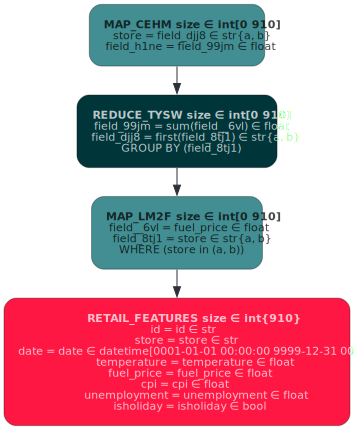

In [9]:
relation = dataset.sql("SELECT store, SUM(fuel_price) FROM retail.features WHERE store IN ('a', 'b') GROUP BY store ")
display(graphviz.Source(relation.dot()))

## DP Compilation

The compilation into DP is done in 3 steps: 
- **Protect** the input `Relation` as described before
- **DP-compilation of the grouping keys**: a grouping key can be released if already public or if it appears in enough users rows,
- **Add noise** scaled by the privacy parameters to each aggregation. 


We use the `dp_compile` method that transforms a `Relation` into its differentially private equivalent.

It inputs: 
- the privacy parameters `epsilon` and `delta` scaling the amount of gaussian noise added to the aggregates,
- the privacy parameters `epsilon_tau_thresholding` and `delta_tau_thresholding` input in the tau-thresholding algorithm (if needed), 
- an array containing the protected entities of each table,
- a `Dataset`.

In [10]:
protected_entity = [
    ("stores", [("store", "features", "store")], "id"),
    ("features", [], "id"),
    ("sales", [], "id")
]
epsilon = 1. 
delta  = 5e-4
epsilon_tau_thresholding = 0.5  
delta_tau_thresholding  = 5e-4
query = "SELECT SUM(fuel_price) AS my_sum FROM retail.features WHERE fuel_price > 2.514 AND fuel_price < 3.907"
relation = dataset.sql(query) 
(dp_relation, mechanisms_used) = relation.dp_compile(
    dataset,
    protected_entity,
    epsilon, 
    delta,
    epsilon_tau_thresholding, 
    delta_tau_thresholding
)

The ouput is a tuple made of two elements: 
- The first element is the `Relation` compiled into dp,
- the second element is a `PrivateQuery` which stores the DP mechanims invoked during the compilation. 


In the present case, we have used only a gaussian mechanim since our query contain only a simple aggregate and no `GROUP BY`. 

In [11]:
print(mechanisms_used)

PrivateQuery(Gaussian(116.72545544867067))


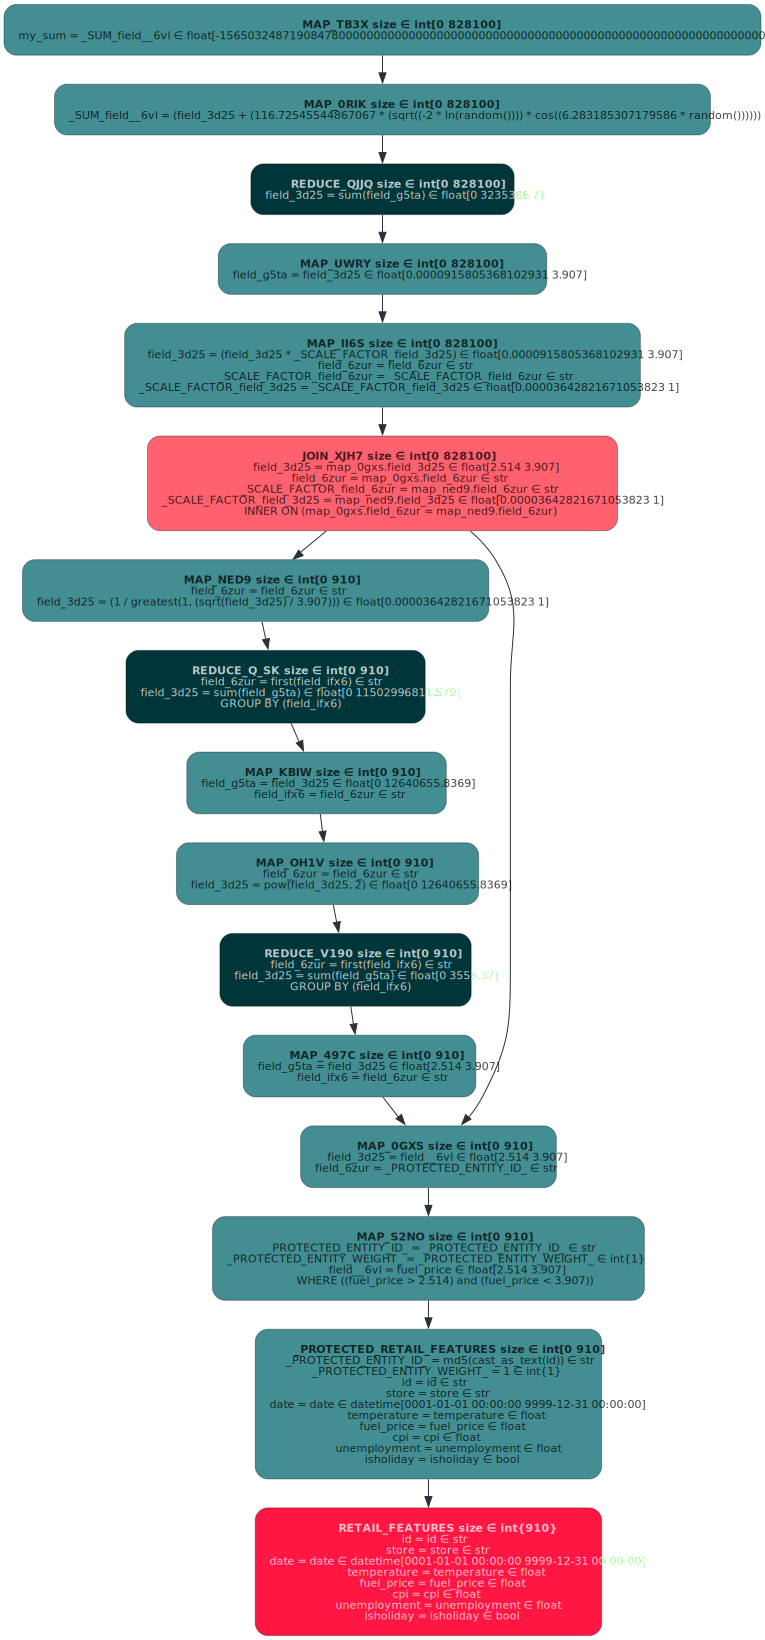

In [12]:
display(graphviz.Source(dp_relation.dot()))

The `Relation` can be translated into an SQL query: 

In [13]:
MAGENTA_COLOR = '\033[35m'  
BLUE_COLOR = '\033[34m'
RESET_COLOR = '\033[0m'    

def print_query(query: str):
    keywords = ["SELECT", "AS", "GROUP BY", "LIMIT", "ORDER BY", "WHERE"]
    colored_query = query
    colored_query = colored_query.replace("WITH", "WITH\n ")
    colored_query = colored_query.replace(" SELECT", "\nSELECT")
    colored_query = colored_query.replace("),", "),\n ") 
    for word in keywords:
        colored_query = colored_query.replace(word, MAGENTA_COLOR + word + RESET_COLOR)
    colored_query = colored_query.replace("WITH", BLUE_COLOR + "WITH" + RESET_COLOR)
    print(colored_query)


dp_query = dp_relation.render()
print_query(dp_query)

WITH
  _PROTECTED_retail_features (_PROTECTED_ENTITY_ID_, _PROTECTED_ENTITY_WEIGHT_, id, store, date, temperature, fuel_price, cpi, unemployment, isholiday) AS (SELECT md5(CAST(id AS VARCHAR)) AS _PROTECTED_ENTITY_ID_, 1 AS _PROTECTED_ENTITY_WEIGHT_, id AS id, store AS store, date AS date, temperature AS temperature, fuel_price AS fuel_price, cpi AS cpi, unemployment AS unemployment, isholiday AS isholiday FROM retail.features AS retail_features),
  map_s2no (_PROTECTED_ENTITY_ID_, _PROTECTED_ENTITY_WEIGHT_, field__6vl) AS (SELECT _PROTECTED_ENTITY_ID_ AS _PROTECTED_ENTITY_ID_, _PROTECTED_ENTITY_WEIGHT_ AS _PROTECTED_ENTITY_WEIGHT_, fuel_price AS field__6vl FROM _PROTECTED_retail_features WHERE ((fuel_price) > (2.514)) AND ((fuel_price) < (3.907))),
  map_0gxs (field_3d25, field_6zur) AS (SELECT field__6vl AS field_3d25, _PROTECTED_ENTITY_ID_ AS field_6zur FROM map_s2no),
  map_497c (field_g5ta, field_ifx6) AS (SELECT field_3d25 AS field_g5ta, field_6zur AS field_ifx6 FROM map_0gxs),
 

Then the query is sent to the databqe: 

In [14]:
import pandas as pd 
true_res = pd.DataFrame(database.execute(query))
dp_res = pd.DataFrame(database.eval(dp_relation))

print(f"Initial query: {true_res.iloc[0][0]}")
print("DP query:     ", dp_res["my_sum"][0])

Initial query: 2939.4329999999995
DP query:      2802.5236190165733


We can sent the DP query multiple times wo see the variantions among the results: 

In [15]:
N_RUNS = 300

def run(dataset, query, epsilons):
    data = {}
    protected_entity = [
        ("stores", [("store", "features", "store")], "id"),
        ("features", [], "id"),
        ("sales", [], "id")
    ]
    delta  = 1e-3
    relation = dataset.sql(query)
    for epsilon in epsilons: 
        (dp_relation, _) = relation.dp_compile(
            dataset,
            protected_entity,
            epsilon, 
            delta,
            epsilon, 
            delta
        )
        data[epsilon] = [
            database.eval(dp_relation)[0][0] for _ in range(N_RUNS)
        ]
    return data

In [16]:
true_value = pd.DataFrame(database.execute(query)).iloc[0][0]
data = run(dataset, query, [0.5, 1., 5.])

In [17]:
import matplotlib.pyplot as plt

def plot_hist(true_value, data, query):
    plt.axvline(true_value, color='red', label="True")
    for e, d in data.items():
        plt.hist(d, bins=30, alpha=0.5, label = f"eps = {e}")
    plt.legend()
    plt.title(query)

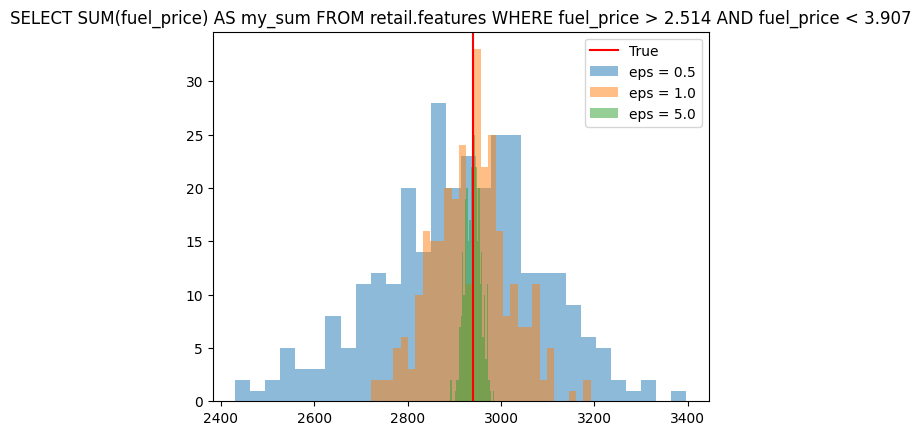

In [18]:
plot_hist(true_value, data, query)